# 模型选择、欠拟合和过拟合

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

### 生成数据集

首先，我们需要数据。给定$x$，我们将使用以下三阶多项式来生成训练和测试数据的标签：

$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2).$$

噪声项$\epsilon$服从均值为0且标准差为0.1的正态分布。在优化的过程中，我们通常希望避免非常大的梯度值或损失值。这就是我们将*特征*从$x^i$调整为$\frac{x^i}{i!}$的原因，这样可以避免对于很大的$i$得到特别大的指数值。我们将为训练集和测试集各合成100个样本。


In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1,-1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

看一下前两个样本

In [3]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.4808],
         [-1.2272]]),
 tensor([[ 1.0000e+00, -4.8082e-01,  1.1560e-01, -1.8527e-02,  2.2270e-03,
          -2.1416e-04,  1.7162e-05, -1.1789e-06,  7.0853e-08, -3.7853e-09,
           1.8201e-10, -7.9557e-12,  3.1877e-13, -1.1790e-14,  4.0493e-16,
          -1.2980e-17,  3.9006e-19, -1.1032e-20,  2.9470e-22, -7.4579e-24],
         [ 1.0000e+00, -1.2272e+00,  7.5305e-01, -3.0805e-01,  9.4514e-02,
          -2.3198e-02,  4.7449e-03, -8.3187e-04,  1.2761e-04, -1.7401e-05,
           2.1355e-06, -2.3825e-07,  2.4366e-08, -2.3002e-09,  2.0163e-10,
          -1.6497e-11,  1.2653e-12, -9.1344e-14,  6.2278e-15, -4.0226e-16]]),
 tensor([ 3.9838, -0.8609]))

实现一个函数来评估模型在给定数据集上的损失

In [4]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)  # 损失的总和, 样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

定义训练函数

In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式特征中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

### 三阶多项式函数拟合(正态)

weight: [[ 5.0135717  1.3508536 -3.4156091  5.128729 ]]


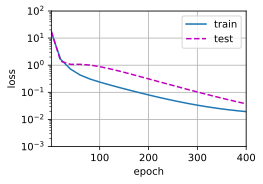

In [6]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

### 线性函数拟合(欠拟合)

weight: [[3.7977045 3.2206762]]


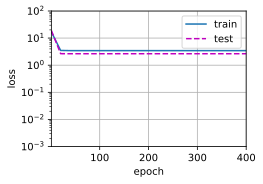

In [7]:
# 从多项式特征中选择前2个维度，即 1, x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

### 高阶多项式函数拟合(过拟合)

weight: [[ 4.9865603   1.2511449  -3.2733696   5.3045583  -0.50323266  1.0441713
   0.10415662  0.03293074 -0.20018525 -0.07525058  0.13166684 -0.01062546
   0.07663539  0.06715228  0.1376793  -0.20864992 -0.1013298  -0.1149036
  -0.05261741  0.17634636]]


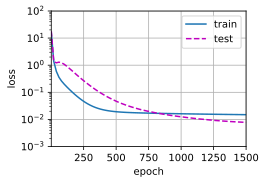

In [8]:
# Pick all the dimensions from the polynomial features
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)